<a href="https://colab.research.google.com/github/SarmenSinanian/DS-Unit-2-Regression-Classification/blob/master/Sarmen_Sinanian_Regression_Classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Do the [Plotly Dash](https://dash.plot.ly/) Tutorial, Parts 1 & 2.
- [ ] Add your own stretch goal(s) !

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

You'll continue to predict how much it costs to rent an apartment in NYC, using the dataset from renthop.com.

 Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
 Engineer at least two new features. (See below for explanation & ideas.)
 Fit a linear regression model with at least two features.
 Get the model's coefficients and intercept.
 Get regression metrics RMSE, MAE, and  R2 , for both the train and test data.
 What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
 As always, commit your notebook to your fork of the GitHub repo.

In [0]:
%matplotlib inline
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [5]:
df.dtypes

bathrooms               float64
bedrooms                  int64
created                  object
description              object
display_address          object
latitude                float64
longitude               float64
price                     int64
street_address           object
interest_level           object
elevator                  int64
cats_allowed              int64
hardwood_floors           int64
dogs_allowed              int64
doorman                   int64
dishwasher                int64
no_fee                    int64
laundry_in_building       int64
fitness_center            int64
pre-war                   int64
laundry_in_unit           int64
roof_deck                 int64
outdoor_space             int64
dining_room               int64
high_speed_internet       int64
balcony                   int64
swimming_pool             int64
new_construction          int64
terrace                   int64
exclusive                 int64
loft                      int64
garden_p

In [0]:
# Making "month_created" column with the column 'created' being converted to datetime
df['created']= pd.to_datetime(df['created'])

In [0]:
# Creating columns with month/day/year separation
df['month_created'] = df['created'].dt.month
df['year_created'] = df['created'].dt.year
df['day_created'] = df['created'].dt.day

In [8]:
combo = (df['pre-war'] ==1) & (df['new_construction'] == 1)
df[combo].year_created

482      2016
556      2016
822      2016
957      2016
1576     2016
1643     2016
1949     2016
2026     2016
2057     2016
2110     2016
2193     2016
2346     2016
2459     2016
2531     2016
2736     2016
2849     2016
2906     2016
2954     2016
3188     2016
3548     2016
3771     2016
3868     2016
3975     2016
3986     2016
3988     2016
4476     2016
4651     2016
4769     2016
5206     2016
5358     2016
         ... 
43012    2016
43196    2016
43461    2016
43685    2016
43792    2016
44464    2016
44612    2016
44917    2016
45037    2016
45046    2016
45066    2016
45552    2016
45786    2016
45956    2016
46561    2016
46755    2016
46983    2016
47026    2016
47156    2016
47214    2016
47426    2016
47479    2016
47741    2016
47787    2016
48753    2016
49118    2016
49162    2016
49209    2016
49210    2016
49293    2016
Name: year_created, Length: 226, dtype: int64

In [9]:
df.dtypes

bathrooms                      float64
bedrooms                         int64
created                 datetime64[ns]
description                     object
display_address                 object
latitude                       float64
longitude                      float64
price                            int64
street_address                  object
interest_level                  object
elevator                         int64
cats_allowed                     int64
hardwood_floors                  int64
dogs_allowed                     int64
doorman                          int64
dishwasher                       int64
no_fee                           int64
laundry_in_building              int64
fitness_center                   int64
pre-war                          int64
laundry_in_unit                  int64
roof_deck                        int64
outdoor_space                    int64
dining_room                      int64
high_speed_internet              int64
balcony                  

In [10]:
print(len(df.columns))

37


In [0]:
df['interest_level'].replace(to_replace = "low", value = 1, inplace = True)
df['interest_level'].replace(to_replace = "medium", value = 2, inplace = True)
df['interest_level'].replace(to_replace = "high", value = 3, inplace = True)

In [12]:
df.interest_level.value_counts()

1    33946
2    11181
3     3690
Name: interest_level, dtype: int64

In [13]:
# Checking the different values for "year_created" column
df.year_created.value_counts()

2016    48817
Name: year_created, dtype: int64

In [14]:
df.isna().sum()

bathrooms                  0
bedrooms                   0
created                    0
description             1425
display_address          133
latitude                   0
longitude                  0
price                      0
street_address            10
interest_level             0
elevator                   0
cats_allowed               0
hardwood_floors            0
dogs_allowed               0
doorman                    0
dishwasher                 0
no_fee                     0
laundry_in_building        0
fitness_center             0
pre-war                    0
laundry_in_unit            0
roof_deck                  0
outdoor_space              0
dining_room                0
high_speed_internet        0
balcony                    0
swimming_pool              0
new_construction           0
terrace                    0
exclusive                  0
loft                       0
garden_patio               0
wheelchair_access          0
common_outdoor_space       0
month_created 

In [0]:
prewar_yes = df[df['pre-war'] == 1]
prewar_no = df[df['pre-war'] == 0]

In [16]:
# Creates list of all columns
column = []
for col in df.columns: 
  column.append(col)
print(column) 


['bathrooms', 'bedrooms', 'created', 'description', 'display_address', 'latitude', 'longitude', 'price', 'street_address', 'interest_level', 'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed', 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building', 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck', 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony', 'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft', 'garden_patio', 'wheelchair_access', 'common_outdoor_space', 'month_created', 'year_created', 'day_created']


In [17]:
# Names a column based on the tick within a range
for x in range(10):
  column_len = len(df.columns)
  print((column[(x)]))

bathrooms
bedrooms
created
description
display_address
latitude
longitude
price
street_address
interest_level


In [18]:
df2=df[df['bathrooms'] == 0]
df2.describe()

,bathrooms,bedrooms,latitude,longitude,price,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,month_created,year_created,day_created
count,304.0,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.0,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.0,304.000000,304.0,304.000000
mean,0.0,0.855263,40.756526,-73.970022,3313.194079,1.016447,0.414474,0.203947,0.115132,0.151316,0.305921,0.105263,0.375000,0.0,0.236842,0.016447,0.085526,0.095395,0.039474,0.055921,0.013158,0.072368,0.003289,0.009868,0.013158,0.226974,0.019737,0.023026,0.006579,0.0,5.062500,2016.0,15.526316
std,0.0,1.014144,0.042624,0.027225,1925.890227,0.127398,0.493443,0.403595,0.319707,0.358947,0.461556,0.307398,0.484921,0.0,0.425846,0.127398,0.280124,0.294244,0.195040,0.230148,0.114139,0.259524,0.057354,0.099012,0.114139,0.419566,0.139324,0.150234,0.080977,0.0,0.824166,0.0,7.171586
min,0.0,0.000000,40.609800,-74.034600,1466.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.000000,2016.0,2.000000
25%,0.0,0.000000,40.731600,-73.992600,2400.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.000000,2016.0,11.000000
50%,0.0,1.000000,40.758500,-73.970100,2700.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.000000,2016.0,15.000000
75%,0.0,2.000000,40.779475,-73.950000,3356.250000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.000000,2016.0,21.000000
max,0.0,4.000000,40.878800,-73.835100,15000.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,6.000000,2016.0,30.000000


In [0]:
# Calculates then prints the mean price of a binary categorical variable/column
def binary_categorical_variable_mean_price(some_df):
  column = []
  for col in some_df.columns:
    column.append(col)
    
  column_length = len(some_df.columns)
  
  for x in range (column_length):
    yes = some_df[some_df[column[x]] == 1]
    no = some_df[some_df[column[x]] == 0]
    print(f'{column[x]} yes: {yes.price.mean()}')
    print(f'{column[x]} no: {no.price.mean()}')

In [20]:
dogs_cats = df[(df['dogs_allowed'] == 1) & (df['cats_allowed'] == 1)]
dogs_cats.price.mean()

3698.938439677301

In [21]:
binary_categorical_variable_mean_price(df)

bathrooms yes: 3040.698074172456
bathrooms no: 3313.1940789473683
bedrooms yes: 3062.9187272378763
bedrooms no: 2486.5520017172908
created yes: nan
created no: nan
description yes: nan
description no: nan
display_address yes: nan
display_address no: nan
latitude yes: nan
latitude no: nan
longitude yes: nan
longitude no: nan
price yes: nan
price no: nan
street_address yes: nan
street_address no: nan
interest_level yes: 3808.043628115242
interest_level no: nan
elevator yes: 3926.99457476289
elevator no: 3195.856397654768
cats_allowed yes: 3674.295785506253
cats_allowed no: 3492.7619851584277
hardwood_floors yes: 3766.423933527497
hardwood_floors no: 3408.3060583454394
dogs_allowed yes: 3697.8363536518395
dogs_allowed no: 3483.7564620804746
doorman yes: 4145.989344262295
doorman no: 3161.1922213911744
dishwasher yes: 4048.011350737798
dishwasher no: 3247.1723401274776
no_fee yes: 3885.6112723214287
no_fee no: 3402.092727449267
laundry_in_building yes: 3434.5954968944097
laundry_in_buildin

In [0]:
columns = ('longitude','latitude','price')

df_seaborn = df.filter(['longitude','latitude','price', 'interest_level'])

In [0]:
df_seaborn_pivot = df_seaborn.pivot_table(values=['price'], index = ['longitude'], columns = ['latitude'])

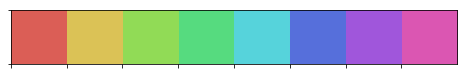

In [24]:
import seaborn as sns

sns.palplot(sns.color_palette("hls", 8))
pal = sns.diverging_palette(240, 10, n=9)


#TIPS ON TRANSPOSING THE BELOW FOR PROPER DISPLAY?

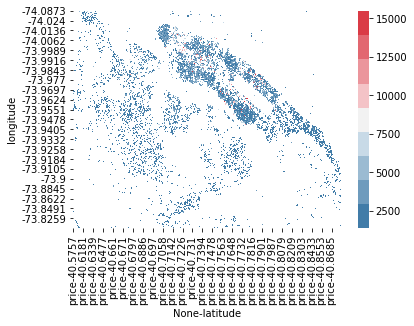

In [25]:
sns.heatmap(data = df_seaborn_pivot, cmap=pal)

 # Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.

In [0]:
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.

In [0]:
# Creating different dfs for train and test

mask_train = (df['month_created'] >= 4) & (df['month_created'] <= 5)
mask_test = (df['month_created'] == 6)

df_train = df[mask_train]
df_test = df[mask_test]

In [28]:
# Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split (X,y, random_state=11)

df_train.shape, df_test.shape

((31844, 37), (16973, 37))

#Engineer at least two new features. (See below for explanation & ideas.)

In [0]:
amenities = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
                 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
                 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
                 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
                 'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
                 'loft', 'garden_patio', 'common_outdoor_space', 
                 'wheelchair_access']

df['amenities'] = df[amenities].sum(axis=1)

In [0]:
# dogs_cats feature being created as a true/false column

df['dogs_cats'] = (df['dogs_allowed'] == 1) & (df['cats_allowed'] == 1) == True

df['dogs_cats'] = (df['dogs_cats'] == True).astype(int)

# df['dogs_cats'] = ""

# if df['dogs_cats'] == True:
#   df['dogs_cats_number'] = 1
# else:
#   df['dogs_cats_number'] = 0

In [0]:
df['long_lat'] = df['longitude']/df['latitude']
df['bath_bed'] = df['bathrooms']/df['bedrooms']
# df['longitude/latitude']

In [50]:
df.bath_bed.value_counts()

1.000000    19014
0.500000    12240
inf          9166
0.333333     3603
0.666667     2772
0.250000      366
0.750000      343
2.000000      206
1.500000      188
0.000000      153
0.400000      129
0.833333      128
1.250000       83
0.375000       61
0.625000       38
0.600000       35
0.800000       31
0.875000       27
1.166667       24
3.000000       14
1.333333       12
0.200000       10
1.125000        7
0.300000        5
0.700000        3
2.500000        2
1.750000        1
0.416667        1
4.500000        1
5.000000        1
0.166667        1
0.428571        1
Name: bath_bed, dtype: int64

In [0]:
df.replace([np.inf, -np.inf], np.nan)
df.bath_bed.replace([np.inf, -np.inf], np.nan).dropna(inplace = True)

In [61]:
df.bath_bed.value_counts()

1.000000    19014
0.500000    12240
inf          9166
0.333333     3603
0.666667     2772
0.250000      366
0.750000      343
2.000000      206
1.500000      188
0.000000      153
0.400000      129
0.833333      128
1.250000       83
0.375000       61
0.625000       38
0.600000       35
0.800000       31
0.875000       27
1.166667       24
3.000000       14
1.333333       12
0.200000       10
1.125000        7
0.300000        5
0.700000        3
2.500000        2
1.750000        1
0.416667        1
4.500000        1
5.000000        1
0.166667        1
0.428571        1
Name: bath_bed, dtype: int64

In [0]:
df['bath_bed'] = df[df['bath_bed'] != np.inf]

In [70]:
df.bathrooms.value_counts()

1.0     39152
2.0      7619
3.0       680
1.5       645
0.0       304
2.5       256
4.0        93
3.5        55
4.5         8
5.0         4
10.0        1
Name: bathrooms, dtype: int64

In [71]:
df.bath_bed.value_counts()

1.0     39152
2.0      7619
3.0       680
1.5       645
0.0       304
2.5       256
4.0        93
3.5        55
4.5         8
5.0         4
10.0        1
Name: bath_bed, dtype: int64

In [32]:
df.tail()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,month_created,year_created,day_created,amenities,dogs_cats,longitude/latitude
49347,1.0,2,2016-06-02 05:41:05,"30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...",E 30 St,40.7426,-73.9790,3200,230 E 30 St,2,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2016,2,5,0,-1.815765
49348,1.0,1,2016-04-04 18:22:34,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,40.7102,-74.0163,3950,225 Rector Place,1,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,4,2016,4,9,1,-1.818127
49349,1.0,1,2016-04-16 02:13:40,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,40.7601,-73.9900,2595,341 West 45th Street,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2016,16,5,1,-1.815256
49350,1.0,0,2016-04-08 02:13:33,Stylishly sleek studio apartment with unsurpas...,Wall Street,40.7066,-74.0101,3350,37 Wall Street,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2016,8,5,1,-1.818135
49351,1.0,2,2016-04-12 02:48:07,Look no further!!! This giant 2 bedroom apart...,Park Terrace East,40.8699,-73.9172,2200,30 Park Terrace East,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2016,12,1,0,-1.808598


In [34]:
df.dtypes

bathrooms                      float64
bedrooms                         int64
created                 datetime64[ns]
description                     object
display_address                 object
latitude                       float64
longitude                      float64
price                            int64
street_address                  object
interest_level                   int64
elevator                         int64
cats_allowed                     int64
hardwood_floors                  int64
dogs_allowed                     int64
doorman                          int64
dishwasher                       int64
no_fee                           int64
laundry_in_building              int64
fitness_center                   int64
pre-war                          int64
laundry_in_unit                  int64
roof_deck                        int64
outdoor_space                    int64
dining_room                      int64
high_speed_internet              int64
balcony                  

# Fit a linear regression model with at least two features.


In [72]:
from sklearn.linear_model import LinearRegression

# Looking for its error value
model = LinearRegression()

# Assign X matrix and y vector
# features = ['dogs_cats','amenities', 'longitutde/latitude', 'bed_bath']
features = ['bath_bed']
target = 'price'


X = df[features]
y = df[target]
model.fit(X,y)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Get the model's coefficients and intercept.

In [73]:
model.intercept_, model.coef_

(486.93308019286815, array([2573.3619831]))

In [74]:
df.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space',
       'month_created', 'year_created', 'day_created', 'amenities',
       'dogs_cats', 'longitude/latitude', 'long_lat', 'bath_bed'],
      dtype='object')

# Get regression metrics RMSE, MAE, and R2 , for both the train and test data.

In [0]:
df_train = df[mask_train]
df_test = df[mask_test]

In [0]:
#   Visualize linear regression, witah squared errors,
#   in 2D: 1 feature + 1 target.
    
#     Use the m & b parameters to "fit the model" manually
    
#     df : Pandas DataFrame
#     feature : string, feature column in df
#     target : string, target column in df
#     m : numeric, slope for linear equation
#     b : numeric, intercept for linear requation
import matplotlib.pyplot as plt

def regression_squared_errors(df, feature, target, m, b):
      # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
#     # Plot squared errors
#     xmin, xmax = ax.get_xlim()
#     ymin, ymax = ax.get_ylim()
#     scale = (xmax-xmin)/(ymax-ymin)
#     for x, y1, y2 in zip(x, y, y_pred):
#         bottom_left = (x, min(y1, y2))
#         height = abs(y1 - y2)
#         width = height * scale
#         ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)

# QUESTION: Do I need to use the training data, testing data, and/or the original data for the previous regression_squared_errors function?

Mean Squared Error: 1638854.7936132331
Root Mean Squared Error: 1280.1776414284204
Mean Absolute Error: 889.7631877413652
R^2: 0.4723751542315733


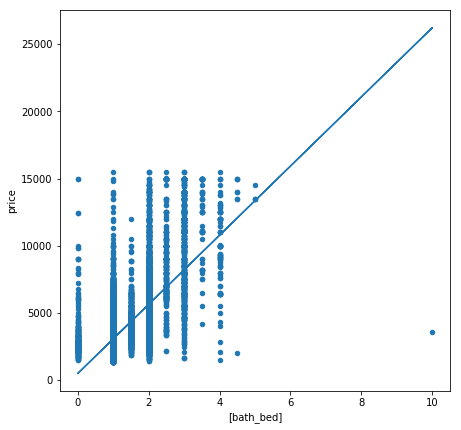

In [89]:
regression_squared_errors(df, features, target, m=model.coef_, b=model.intercept_)

# What's the best test MAE you can get? Share your score and features used with your cohort on Slack!

# As always, commit your notebook to your fork of the GitHub repo.


Feature Engineering "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, "A Few Useful Things to Know about Machine Learning"

"Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, Machine Learning and AI via Brain simulations

Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work.